In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import time
import sys
from PIL import Image
from imageai.Detection import ObjectDetection
from tkinter import Tk
from tkinter.filedialog import askopenfilename

sys.path.append('../Python')
from drawboxes import *

/home/harisankar/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/harisankar/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/harisankar/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/harisankar/.local/lib/python3.6/site-packages/tensorflow/python/framework

In [2]:
config = {
    "saveslices" : True,
    "drawboxes" : True,
    "saveFinalDetections" : True
}

In [3]:
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename = askopenfilename() # show an "Open" dialog box and return the path to the selected file
filename = filename.split('/')[-1]
print(filename)

cars.jpg


In [4]:
model_path = '../models/'
model_name = 'yolo.h5'
model_weight = model_path + model_name

In [5]:
input_path = '../input/images/'
output_path = '../output/images/'
result_path = '../output/result/'
file_name = filename
output_file = output_path + file_name
result_file = result_path + file_name.split('.')[0] + '.txt'
input_file = input_path + file_name

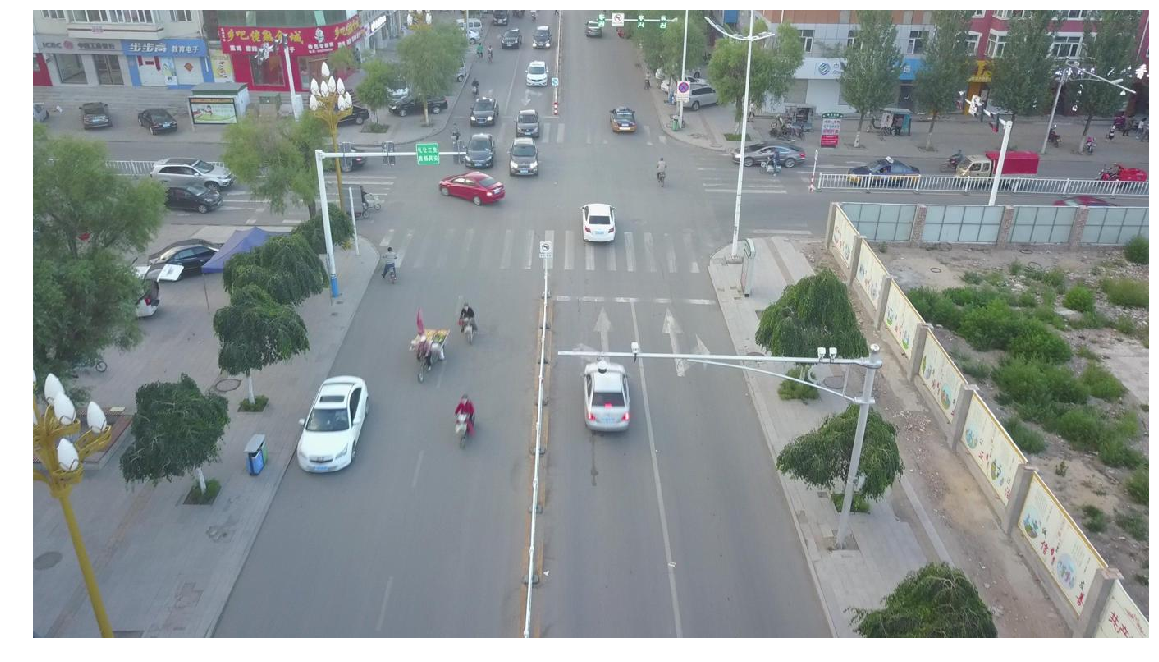

In [6]:
image = tf.keras.preprocessing.image.load_img(input_file)   #Load image
plt.figure(figsize=(20,35.55))
plt.axis("off")
plt.imshow(image)
image = tf.keras.preprocessing.image.img_to_array(image)    #Converting image to numpy array

In [7]:
shape = image.shape
height = shape[0]
width = shape[1]
offset_height = 0.05 * height
offset_width = 0.03 * width
vert_pieces = 2
horiz_pieces = 2
crop_height = int(math.ceil(height/vert_pieces + offset_height))
crop_width = int(math.ceil(width/horiz_pieces + offset_width))

In [8]:
# Calculate crop coordinates
boxes = []
x1 = 0
y1 = 0
for i in range(vert_pieces):
    y = y1 + crop_height/height
    for j in range(horiz_pieces):
        x = x1 + crop_width/width
        if(y > 1):
            y = 1
        if(x > 1):
            x = 1
        boxes.append([y1,x1,y,x])
        x1 = x - (2*offset_width)/width
    x1 = 0
    y1 = y - (2*offset_height)/height
boxes = np.array(boxes)

In [9]:
# Prepocessing image for tensorflow function compatibility
images = []
images.append(image)
images = np.array(images)
num_boxes = boxes.shape[0]
box_indices = np.zeros(num_boxes)

In [10]:
# Crop Images
crop_tensor = tf.image.crop_and_resize(images, boxes, box_indices, crop_size=[crop_height,crop_width], method='bilinear', extrapolation_value=0, name=None)
cropped_images = crop_tensor.eval(session=tf.Session())

Instructions for updating:
box_ind is deprecated, use box_indices instead


In [11]:
if(config["drawboxes"]):
    draw_boxes = [boxes]
    draw_boxes = np.array(draw_boxes)
    draw_tensor = tf.image.draw_bounding_boxes(images, draw_boxes, name=None) 
    draw_img = draw_tensor.eval(session=tf.Session())
    drawn_img = tf.keras.preprocessing.image.array_to_img(draw_img[0],data_format=None, scale=True, dtype=None)
    name = output_path+file_name.split('.')[0]+"_boxes.jpg"
    drawn_img.save(name)
    

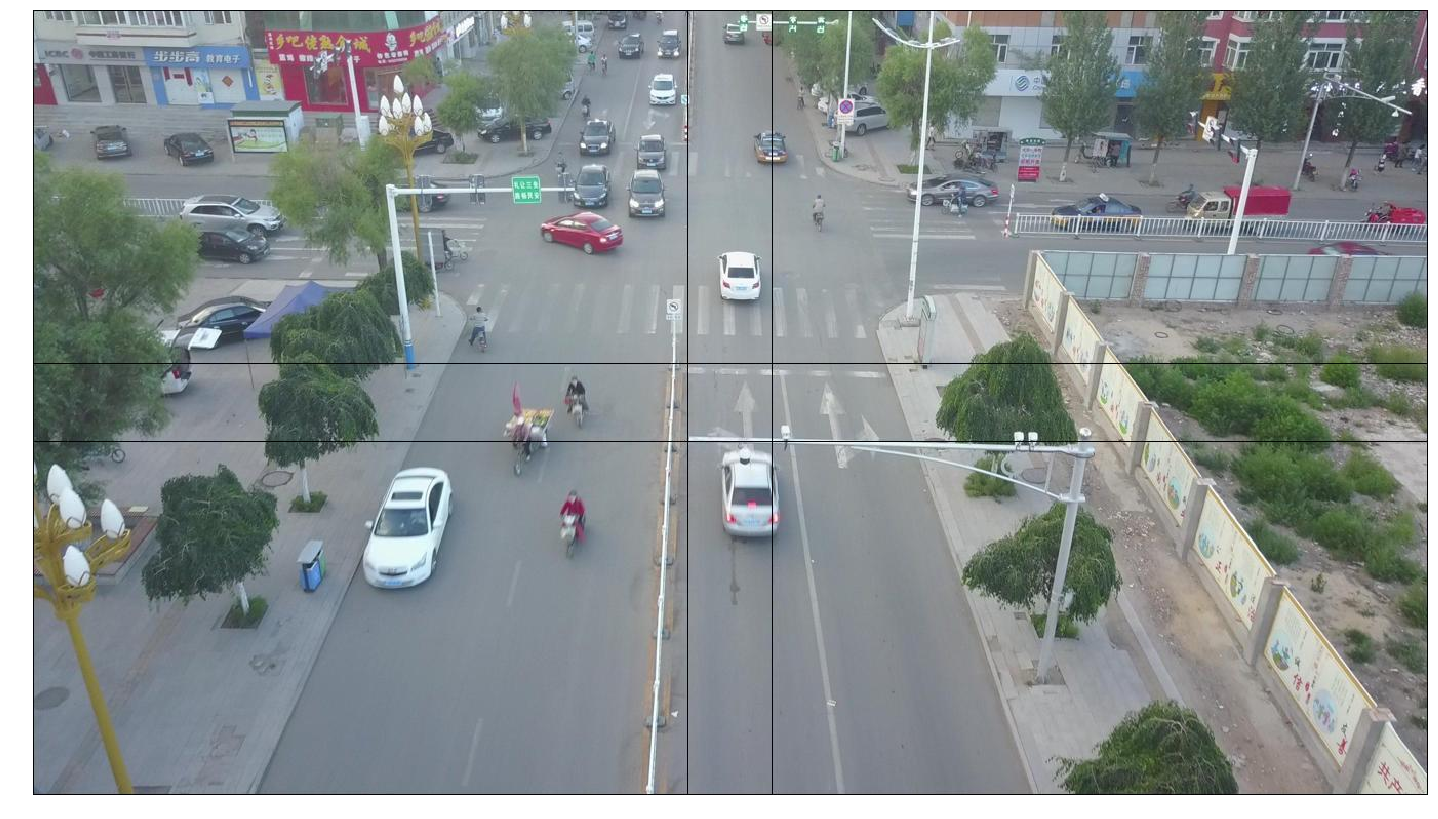

In [12]:
box_image = tf.keras.preprocessing.image.load_img(name)   #Load image
plt.figure(figsize=(25,44.44))
plt.axis("off")
plt.imshow(box_image)

In [13]:
if(config["saveslices"]):
    for i in range(num_boxes):
        result = tf.keras.preprocessing.image.array_to_img(cropped_images[i],data_format=None, scale=True, dtype=None)
        name = output_path+file_name.split('.')[0]+"_crop"+str(i)+".jpg"
        result.save(name)


In [14]:
detector = ObjectDetection()
detector.setModelTypeAsYOLOv3()
detector.setModelPath(model_weight)
detector.loadModel()
temp_img, crop_det = detector.detectObjectsFromImage(input_image=cropped_images[i],input_type="array", output_type="array",minimum_percentage_probability=30)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [15]:
tic = time.time()
crop_detections = []
for i in range(num_boxes):
    temp_img, crop_det = detector.detectObjectsFromImage(input_image=cropped_images[i],input_type="array", output_type="array",minimum_percentage_probability=30)
    crop_detections.append(crop_det)
    input_crop = output_path+file_name.split('.')[0]+"_crop"+str(i)+".jpg"
    name = output_path+file_name.split('.')[0]+"_cropdet"+str(i)+".jpg"
    drawBoxes(input_crop,name,crop_det)

tac = time.time()
elapsed = tac-tic
print(elapsed)

3.789501905441284


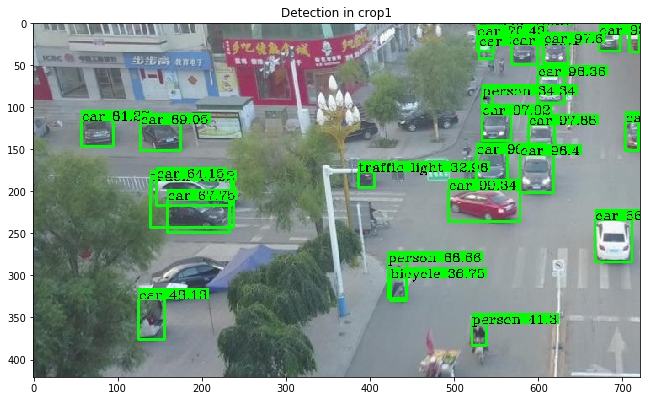

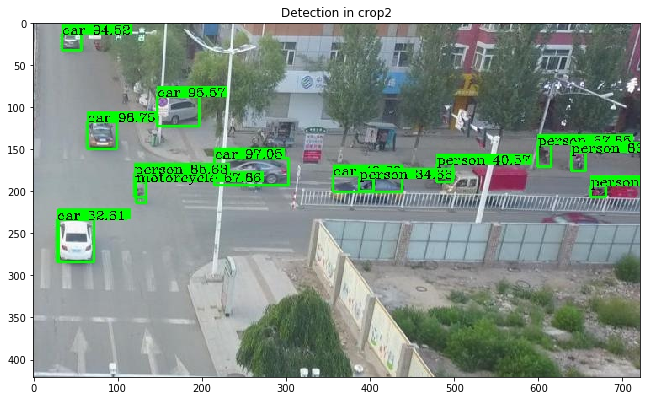

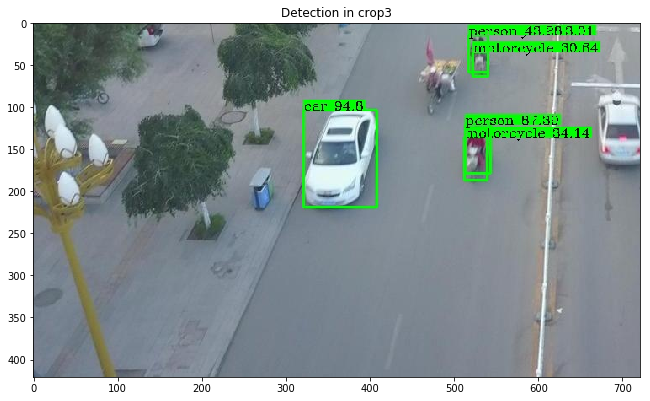

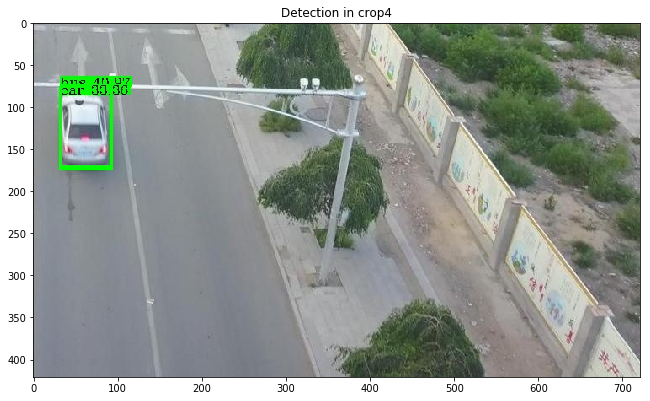

In [16]:
for i in range(num_boxes):
#     plt.axis("off")
    fig = plt.figure(figsize=(50,88.88))
    name = output_path+file_name.split('.')[0]+"_cropdet"+str(i)+".jpg"
    img = tf.keras.preprocessing.image.load_img(name)   #Load image
    a = fig.add_subplot(1, 4, i+1)
    imgplot = a.imshow(img)
    a.set_title('Detection in crop'+str(i+1))

In [17]:
# Aggregate Detections from slices
detected_boxes = []
detections = []
classes = []
scores = []
for i in range(num_boxes):
    size = len(crop_detections[i])
    x = boxes[i][1]*width
    y = boxes[i][0]*height
    for j in range(size):
        detected = crop_detections[i][j]
        
        box = detected['box_points']
        box = [box[0]+x, box[1]+y, box[2]+x, box[3]+y]
        detected['box_points'] = box
        
        name = detected['name']
        if( classes.count(name) > 0 ):
            pos = classes.index(name)
            detected_boxes[pos].append(box)
            scores[pos].append(detected['percentage_probability'])
            detections[pos].append(detected)
            
        else:
            pos = len(classes)
            classes.append(name)
            detected_boxes.append([box])
            scores.append([detected['percentage_probability']])
            detections.append([detected])
            
#         detected_boxes.append(box)
#         scores.append(detected['percentage_probability'])
#         detections.append(detected)
        
detected_boxes = np.array(detected_boxes)
scores = np.array(scores)
print(len(classes), len(detected_boxes), len(detections), len(scores))

7 7 7 7


In [23]:
final_detections = []
for count in range(len(classes)):
    selected_indices = tf.image.non_max_suppression(tf.convert_to_tensor(detected_boxes[count], dtype=tf.float32), tf.convert_to_tensor(scores[count], dtype=tf.float32), len(detected_boxes[count]), 0.3)
    selected_indices = selected_indices.eval(session=tf.Session())
    for index in selected_indices:
        final_detections.append(detections[count][index])

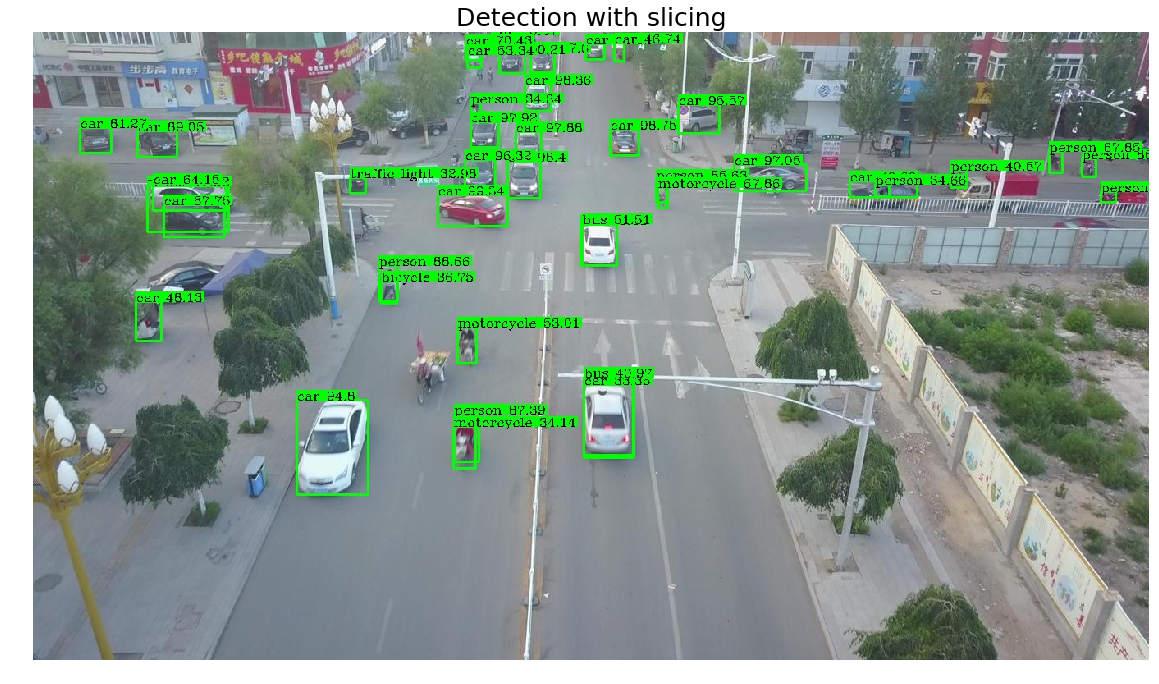

In [25]:
if(config["saveFinalDetections"]):
    name = output_path+file_name.split('.')[0]+"_final_detections.jpg"
    drawBoxes(input_file,name,final_detections)
    img = tf.keras.preprocessing.image.load_img(name)   #Load image
    plt.figure(figsize=(20,35.55))
    plt.title("Detection with slicing",fontdict={'fontsize':25},loc='center')
    plt.axis("off")
    plt.imshow(img)

elapsed: 1.3030316829681396


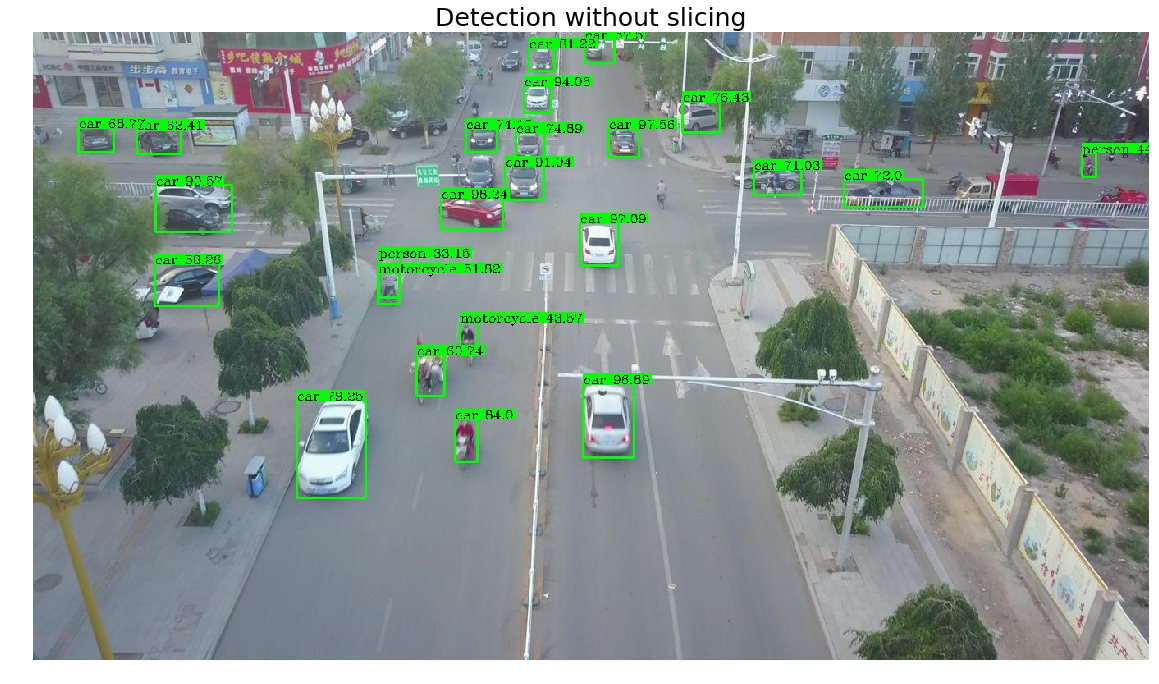

In [26]:
tic = time.time()
temp_img, img_det = detector.detectObjectsFromImage(input_image=images[0],input_type="array", output_type="array",minimum_percentage_probability=30)
name = output_path+file_name.split('.')[0]+"_nocrop_detections.jpg"
drawBoxes(input_file,name,img_det)
img = tf.keras.preprocessing.image.load_img(name)   #Load image
plt.figure(figsize=(20,35.55))
plt.title("Detection without slicing",fontdict={'fontsize':25},loc='center')
plt.axis("off")
plt.imshow(img)
tac =time.time()
print("elapsed: "+str(tac-tic))

In [27]:
print("Number of Detections with slicing: "+str(len(final_detections)))
print("Number of Detections without slicing: "+str(len(img_det)))

Number of Detections with slicing: 43
Number of Detections without slicing: 24
